In order to extract from the universities, you first need the URLS of all the universities. To do this:

1. Go to [the US News list of national universities](https://www.usnews.com/best-colleges/rankings/national-universities). 
2. Open the JavaScript console (`Ctrl` `Shift` `I`, then click on the 'Console' tab)
3. Paste in the following code: `a = document.querySelector('button[class*="LoadMoreWrapper"]'); window.setInterval(() => a.click(), 1000)`, and press enter. This will continue to load more universities on the web page.
4. Wait for a minute or so, until the page stops loading new universities.
5. Save the web page (`Ctrl` `S`) into this folder.

I've already done these steps and saved it here.

Now, we need to extract the URLs from this page. To do this, we'll use BeautifulSoup.

In [11]:
from bs4 import BeautifulSoup

html_doc = open("2022 Best National Universities US News Rankings.htm", encoding="utf8")
soup = BeautifulSoup(html_doc, 'html.parser')

In [12]:
anchors = soup.select('a[class*="card-name"]')
links = list(map(lambda x: x.get('href'), anchors))
print(links[:10])

['https://www.usnews.com/best-colleges/princeton-university-2627', 'https://www.usnews.com/best-colleges/columbia-university-2707', 'https://www.usnews.com/best-colleges/harvard-university-2155', 'https://www.usnews.com/best-colleges/massachusetts-institute-of-technology-2178', 'https://www.usnews.com/best-colleges/yale-university-1426', 'https://www.usnews.com/best-colleges/stanford-university-1305', 'https://www.usnews.com/best-colleges/university-of-chicago-1774', 'https://www.usnews.com/best-colleges/university-of-pennsylvania-3378', 'https://www.usnews.com/best-colleges/california-institute-of-technology-1131', 'https://www.usnews.com/best-colleges/duke-university-2920']


## Page Data Collection

Now we have all of the university links, we need to go individually through each one, request the various sub-pages from the server, then extract the info into a dataframe.

In [185]:
import requests
import pandas as pd

def get_soup_obj(link, subpage):
    url = link + "/" + subpage
    agent = {"User-Agent":'Mozilla/5.0'}
    response = requests.get(url, headers = agent)
    return BeautifulSoup(response.text, 'html.parser')

soup = get_soup_obj(links[0], "academics")

### Direct Extraction
For a lot of the data, we can just directly pull the key-value pair from a data row.

In [190]:
def get_data_rows(soup_obj):
    datarows = soup_obj.select('div[class*="DataRow"]:not([class*="datarow-table"]):not([class*="pie-chart"])')
    # Exclude those with class 'pie-chart' or 'datarow-table', which are dealt with in different functions
    for d in datarows:
        if len(d.contents) == 2 and d.parent.name != "span" and \
        d.contents[1].text != "UNLOCK WITH COMPASS UNLOCK WITH COMPASS":
            # don't include things with 'span' parent because those are list elements
            # and are captured in get_truncated_data_table
            # also exclude data that I can't access because I'm not a premium user
            print(d.contents[0].text + " ::: " + d.contents[1].text)
            
get_data_rows(get_soup_obj(links[0], "rankings"))

Score (out of 100) ::: 100
Average 6-year graduation rate (17.6%) ::: 97%
6-year graduation rate of students who received a Pell Grant (2.5%) ::: 98%
6-year graduation rate of students who did not receive a Pell Grant (2.5%) ::: 98%
Classes with fewer than 20 students ::: 77.6%
Classes with 50 or more students ::: 9%
Student-faculty ratio (1%) ::: 4:1


In [140]:
def get_bar_charts(soup_obj):
    bar_charts = soup_obj.select('div[class*="pie-chart"]') # Yes, all the bar charts are labelled as pie charts
    for b in bar_charts:
        bar_chart_title = b.select('p')[0].text
        for l in b.select('div[class*="BarChartStacked__LegendWrapper"] > div[class*="BarChartStacked__Legend"] > div'):
            print(bar_chart_title + "." + l.contents[1] + " ::: " + l.b.contents[0])
        print("---")

get_bar_charts(soup)

Full-time faculty gender distribution.Male ::: 63.5
Full-time faculty gender distribution.Female ::: 36.5
---
Part-time faculty gender distribution.Male ::: 54.8
Part-time faculty gender distribution.Female ::: 45.2
---
Class sizes.Classes with fewer than 20 students ::: 77.6
Class sizes.20-49 ::: 13.5
Class sizes.50 or more ::: 9
---


### Tidy Data
For many other structures, like a table within a table, doing the same thing as above would result in *untidy data*. So we need to modify our approach by creating separate tables for each of these.  

Unfortunately, it means I have to 'cheat' a little bit -- since I already know the desired labels for each of the data points, I'm going to feed the column headers into the functions. For example, the 'rankings' data should have the headers 'category' and 'rank'.

In [187]:
def get_rankings(soup_obj):
    #rankrows = soup.select('ul[class*="BadgeList"]')
    df_list = []
    rank_rows = soup_obj.select('li[class*="BadgeList"]> div:nth-child(2)')
    for r in rank_rows:
        x = r.select('div:nth-child(1) > a > strong')
        if len(x) >= 2:
            df_list.append([x[0].text, x[1].text])
    print(pd.DataFrame(df_list, columns=['rank', 'category']))
            
get_rankings(get_soup_obj(links[0], "rankings"))

    rank                                   category
0     #1                      National Universities
1     #4                 Best Colleges for Veterans
2     #3                Best Undergraduate Teaching
3     #4                         Best Value Schools
4    #29                    Most Innovative Schools
5   #192          Top Performers on Social Mobility
6    #12    Best Undergraduate Engineering Programs
7    #12                                   Chemical
8    #12                                   Computer
9     #8                           Computer Science
10    #9  Biocomputing/Bioinformatics/Biotechnology
11   #10                      Programming Languages
12    #4                                     Theory
13   #13                 Writing in the Disciplines
14    #6                       Learning Communities
15    #5   Undergraduate Research/Creative Projects
16   #13                     First-Year Experiences
17    #1                            Senior Capstone


In [250]:
def get_truncated_data_tables(soup_obj):
    dfs = {}
    tables = soup_obj.select('div[class*="datarow-table truncated"]')
    for t in tables:
        df_list = []
        table_name = t.select('p')[0].text
        for s in t.select('div[class*="DataRow__Row"]'):
            data = [x.text for x in s.contents]
            df_list.append(data)
            
        if len(df_list[0]) == 2: #Should be the table of majors in the Academics tab
            cols=["major", "percentage"]
        else:
            cols=[table_name]
        df_new = pd.DataFrame(df_list, columns=cols)
        dfs[table_name] = df_new
    return dfs

get_truncated_data_tables(get_soup_obj(links[0], "academics"))

{'Ten most popular majors for 2020 graduates':                                                major percentage
 0                                    Social Sciences        20%
 1                                        Engineering        15%
 2  Computer and Information Sciences and Support ...        12%
 3                 Biological and Biomedical Sciences        10%
 4  Public Administration and Social Service Profe...         9%
 5                                  Physical Sciences         7%
 6                                            History         6%
 7    Foreign Languages, Literatures, and Linguistics         4%
 8            English Language and Literature/Letters         3%
 9                   Philosophy and Religious Studies         3%,
 'Student participation in special academic programs':   Student participation in special academic programs
 0                             First-year experiences
 1                                   Service learning
 2  Senior capstone or

In [ ]:
def get_datarow_tables(soup_obj):
    tables = soup_obj.select('div[class*="datarow-table"]')
    pass

In [240]:
def get_tabular_tables(soup_obj):
    dfs = {}
    tables = soup_obj.select('div[class*="TableTabular__TableInnerWrapper"] > table')
    for t in tables:
        df_list = []
        header_objs = t.thead.tr.select('p[class*="Heading__HeadingStyled"]')
        header_text = [x.text for x in header_objs]
        obs_label = header_text[0]
        cols = header_text[1:]
        for tr in t.tbody.select('tr[class*="TableTabular__TableRow"]'):
            row_text = [x.text for x in tr.select('span')]
            row = row_text[0]
            observations = row_text[1:]
            for col, obs in zip(cols, observations):
                df_list.append([row, col, obs])
        df_new = pd.DataFrame(df_list, columns=["offense", "year", obs_label])
        dfs[obs_label] = df_new
    return dfs

get_tabular_tables(get_soup_obj(links[0], "student-life"))

{'Criminal Offenses -- On-Campus':                               offense  year Criminal Offenses -- On-Campus
 0   Murder/Non-negligent manslaughter  2017                              0
 1   Murder/Non-negligent manslaughter  2018                              0
 2   Murder/Non-negligent manslaughter  2019                              0
 3              Negligent manslaughter  2017                              0
 4              Negligent manslaughter  2018                              0
 5              Negligent manslaughter  2019                              0
 6                                Rape  2017                             12
 7                                Rape  2018                             13
 8                                Rape  2019                              8
 9                              Incest  2017                              0
 10                             Incest  2018                              0
 11                             Incest  2019          

Unfortunately, the truncated HTML objects need the user to press a button to display their full data:
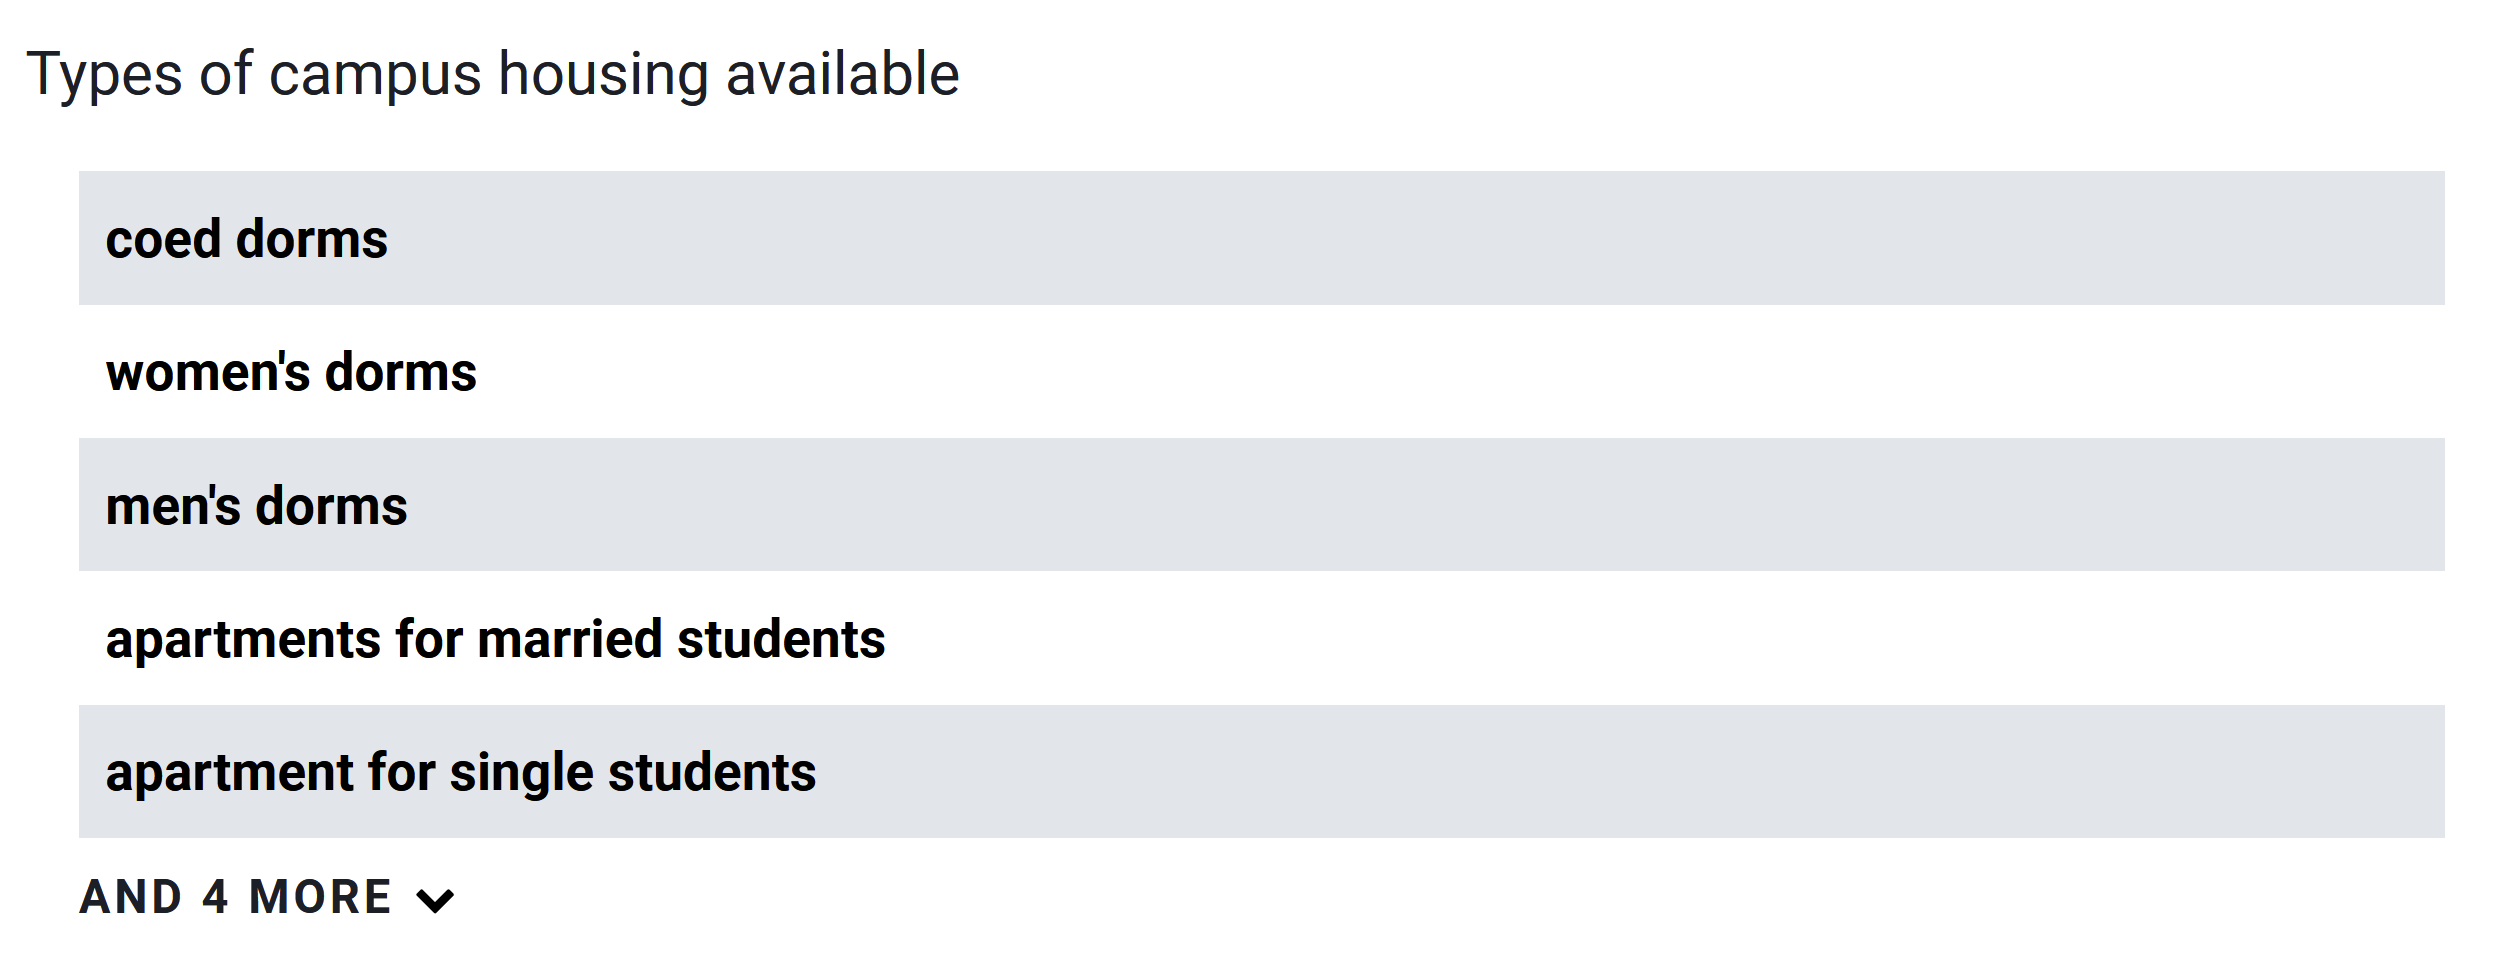
This means that I would need to use Selenium or some other browser simulation to get everything. For now, I'll just get what I can with `requests` and ignore the rest.